## Rural Land Valuation:

Using data scraped from the web, multivariate regression models were built to improve rural land valuation accuracy.

In [1]:
import numpy as np
import pandas as pd
import pickle
import sys
import warnings

# regression modeling:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, RidgeCV, Ridge, Lasso, LassoCV, ElasticNetCV, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import r2_score
from xgboost.sklearn import XGBRegressor
import statsmodels.api as sm
import statsmodels.formula.api as smf
from yellowbrick.regressor import AlphaSelection
import patsy

# visualization modules:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# custom modules:
sys.path.append('../code/')
from Add_GIS_Features import GCP_Features

In [2]:
# IDE settings:
plt.style.use('ggplot')
warnings.filterwarnings('ignore')
pd_options = {
'precision'           : 2,
'display.max_columns' : 30,
'display.width'       : 1000,
}

##### Blacklands North Texas Region

In order to mitigate geographical price variance, properties were selected across 8 contiguous counties comprising the Blacklands North Texas Region. To control for error due to improvements, all properties were filtered to exclude those with homes. 

,id,size,price,address,county,zip,auto_gate,barn,cattle,easement,...,bosque,coryell,falls,freestone,hill,limestone,mclennan,navarro,title,link
0,1396986,220.69,440287,729 cr 3430,bosque,76634,0,0,0,0,...,1,0,0,0,0,0,0,0,"220.69 acres clifton, tx",220.69-acres-in-Bosque-County-Texas/1396986
1,1149611,80,275000,0000 vilas rd,bell,76534,0,0,0,0,...,0,0,0,0,0,0,0,0,"80 acres holland, tx",80-acres-in-Bell-County-Texas/1149611
2,2033595,102,204000,fm 2838,limestone,76667,0,0,0,0,...,0,0,0,0,0,1,0,0,near mexia part woods,102-acres-in-Limestone-County-Texas/2033595
3,1621214,67.55,168875,off fm 933,hill,76622,0,0,0,0,...,0,0,0,0,1,0,0,0,"67.55 acres aquilla, tx",67.55-acres-in-Hill-County-Texas/1621214
4,/867838,50,147500,cr 326,falls,76680,0,0,0,0,...,0,0,1,0,0,0,0,0,"50 acres reagan, tx",50-acres-in-Falls-County-Texas/867838


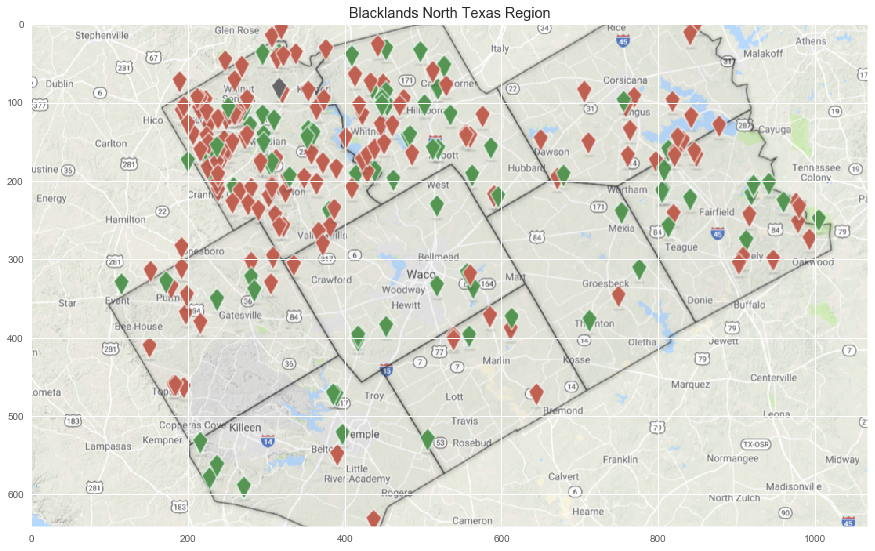

In [3]:
# display map of property region:
img = mpimg.imread('../images/blacklands_region.png')
plt.figure(figsize=(15,12))
plt.title('Blacklands North Texas Region')
plt.imshow(img)

# load dataframe from pickle:
df = pickle.load(open('../data/original_df.pkl', 'rb'))
df.head()

#### Exploratory Data Analysis

The EDA includes the following 6 categories:

* Overview
* Location Distribution
* Residence Filtering
* Outliers
* Feature Correlation
* Liquidy Discount

##### 1 - Overview: 
    
Quickly scanning for max values of 0 below, we make a note of features to exclude for the cleaned dateframe version.

In [4]:
df.describe()

,auto_gate,barn,cattle,easement,exemption,game_fence,home,lake,minerals,paved,...,windmill,word_count,bosque,coryell,falls,freestone,hill,limestone,mclennan,navarro
count,836.0,836.000000,836.000000,836.000000,836.000000,836.000000,836.000000,836.000000,836.000000,836.000000,...,836.000000,836.000000,836.000000,836.000000,836.000000,836.000000,836.000000,836.000000,836.000000,836.000000
mean,0.0,0.035885,0.118421,0.011962,0.014354,0.004785,0.127990,0.069378,0.082536,0.075359,...,0.001196,47.983254,0.113636,0.118421,0.106459,0.102871,0.138756,0.138756,0.100478,0.111244
std,0.0,0.186115,0.323299,0.108779,0.119017,0.069047,0.334279,0.254248,0.275344,0.264128,...,0.034586,48.698089,0.317559,0.323299,0.308609,0.303972,0.345899,0.345899,0.300817,0.314622
min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,38.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,83.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,190.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


##### 2 - Location Distribution: 

Since real estate valuation is significantly a function of physical location, it's imperative to check that our property listings are evenly distributed across counties in the region. 

<BarContainer object of 8 artists>

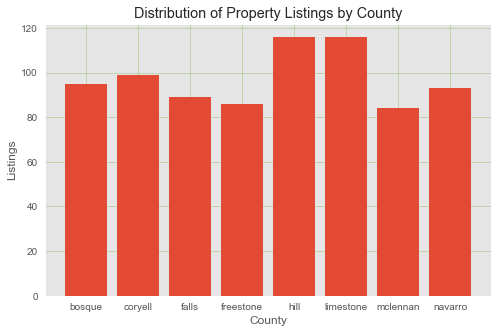

In [5]:
df_county = df[['bosque', 'coryell', 'falls', 'freestone', 'hill',
       'limestone', 'mclennan', 'navarro']].sum()

plt.style.use('ggplot')
plt.figure(figsize=(8,5))
plt.xlabel('County')
plt.ylabel('Listings')
plt.title('Distribution of Property Listings by County')
plt.grid(color = 'g', linewidth = 0.5)
plt.bar(df_county.index, df_county)

##### 3 - Residence Filtering:

Although the pages scraped were within a filter to include only those listings not having homes, it was often the case that the properties had residences. These were filtered out to control for impact of a home on land pricing. 

Target Variable: The real estate industry's land sector uses a price per acre metric to compare intrinsic values across varying property sizes. This target variable was generated below. 

In [6]:
print('Total Properties Retrieved:', df.shape[0])

home_mask = df['home'] == True

if df[home_mask].shape[0] > 0:
    print('Properties with homes:', df[home_mask].shape[0])
    not_home = (df['home'] != True)
    df2 = df[not_home]
    print(f'Properies in filtered dataframe: {df2.shape[0]}\n')

else:
    print('No residence properties in dataframe')
    df2 = df

df2 = df2.drop(columns = ['auto_gate', 'county', 'home', 'id'])

# generate price per acre target:
df2['price'] = df2.price.astype(float)
df2['size'] = df2['size'].astype(float)
df2['price_acre'] = df2['price'] / df2['size']
df2 = df2.drop(columns = ['price'])

df2 = df2[['price_acre', 'size', 'barn', 'cattle', 'easement', 'exemption',
       'game_fence', 'lake', 'minerals', 'paved', 'pond', 'topo', 'water',
       'well', 'windmill', 'bosque', 'coryell', 'falls', 'freestone', 'hill',
       'limestone', 'mclennan', 'navarro', 'word_count', 'address', 'zip']]

df2.head()

Total Properties Retrieved: 836
Properties with homes: 107
Properies in filtered dataframe: 729



,price_acre,size,barn,cattle,easement,exemption,game_fence,lake,minerals,paved,...,coryell,falls,freestone,hill,limestone,mclennan,navarro,word_count,address,zip
0,1995.047351,220.69,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,729 cr 3430,76634
1,3437.500000,80.00,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0000 vilas rd,76534
2,2000.000000,102.00,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,fm 2838,76667
3,2500.000000,67.55,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,off fm 933,76622
4,2950.000000,50.00,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,cr 326,76680


##### 4 - Outliers:

The price per acre distribution below exhibits an extreme left-skew. From domain knowledge, we know that land prices for even the region's most exceptional properties rarely surpass 10,000 per acre. A sample investigation of the 3 highest prices revealed these properties were commercial listings with improvements - a product type not intended for the site. A filter was subsequently applied to remove listings over 10,500. 

9 properties listed with pricing errors removed.



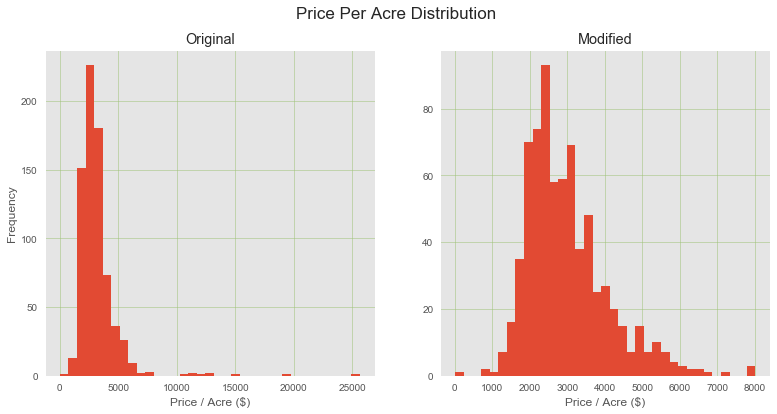

In [7]:
price_dist1 = df2.price_acre  # save original features for plot comparison

# remove outliers likely resulting from mislabeled properties over $10,500 / acre:
price_error = df2[df2.price_acre > 10500]

if price_error.shape[0] > 0:
    print(f'{price_error.shape[0]} properties listed with pricing errors removed.\n')
    df2 = df2.drop(df2[df2.price_acre > 10500].index)
    
price_dist2 = df2.price_acre # save modified features for plot comparison

# plot impact of filter on price distributions:
fig, ax = plt.subplots(1, 2, figsize = (13,6))
fig.suptitle('Price Per Acre Distribution', fontsize = 17, fontweight = 15)

ax[0].set_title('Original')
ax[0].hist(price_dist1, bins = 35)
ax[0].set(ylabel='Frequency')

ax[1].set_title('Modified')
ax[1].hist(price_dist2, bins = 35)

for ax in ax.flat:
    ax.grid(color = 'g', linewidth = 0.5)
    ax.set(xlabel='Price / Acre ($)')

##### 5 - Correlation: 
Plotting the correlation heatmap shows low correlation between features. With real estate land features, some correlation is expected. For example, it is likely for a property with a river to also have a lake and for a property agriculturally exempted from taxes to have facilities that support those activities, such as a barn. 

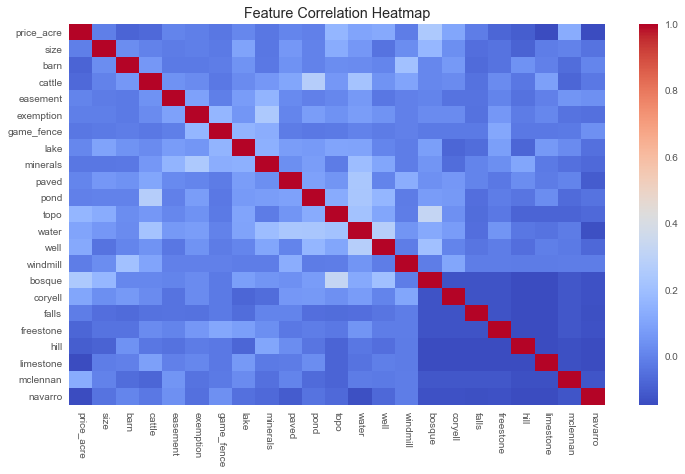

In [8]:
plt.figure(figsize=(12,7))
plt.title('Feature Correlation Heatmap')
sns.heatmap(df2.iloc[:,:23].corr(), cmap='coolwarm', robust = True)
plt.xticks(rotation = -90) 
plt.show()

##### 6 - Liquidity Discount:

As there are more people with less money in the world, there are simply fewer buyers able to afford larger properties on a comparable price / acre. In the complementary case, wealthier buyer have more options and are inclined to maximize this leverage. Thus, larger properties often bend to market forces, incurring a liquidity discount in order to sell. In the visual below, this hypothesis seems to hold as we observe a $4,000 / acre ceiling on properties larger than 600 acres. 

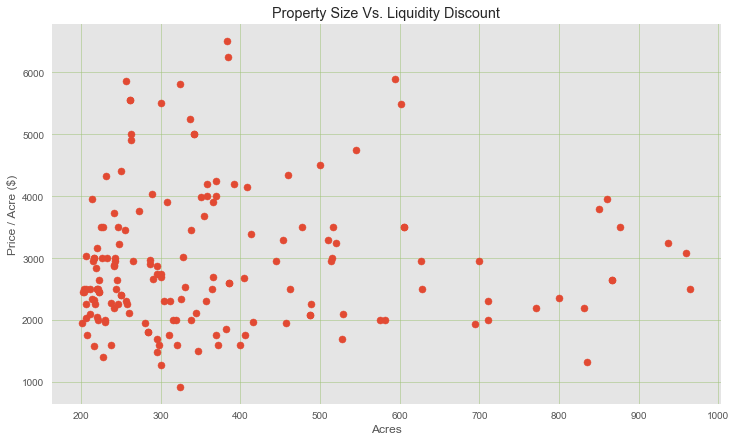

In [9]:
mask = (df2['size'].astype(float) > 200) & (df2['size'].astype(float) < 1000)
df_liquid = df2[mask]

x = df_liquid['size']
y = df_liquid['price_acre']

plt.figure(figsize=(12, 7))
plt.title('Property Size Vs. Liquidity Discount')
plt.xlabel('Acres')
plt.ylabel('Price / Acre ($)')
plt.scatter(x, y)
plt.grid(color = 'g', linewidth = 0.5)

----

#### Regression Part 1: Base Case

The entire dataset was used for initial familiarization (Model-0). The expected over-fitting returned adjusted R^2 returned 81.4% using OLS. 

The cluster of data points predicted under $1,000 per acre indicate the model is lacking sufficient information for these properties. Since the majority of features were extracted from property descriptions, it follows that the model would undervalue listings with short or non-existent descriptions. 

To test this hypothesis, the target was regressed against property description `word_count` and demonstrated a direct correlation or "verbosity premium" of roughly $10 per word per acre. This error was mitigated by applying a filter to drop listings with word counts less than length 10 (see below).

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             price_acre   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.814
Method:                 Least Squares   F-statistic:                     143.8
Date:                Mon, 12 Aug 2019   Prob (F-statistic):          5.73e-242
Time:                        14:18:22   Log-Likelihood:                -6213.7
No. Observations:                 720   AIC:                         1.247e+04
Df Residuals:                     698   BIC:                         1.257e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
size           0.5302      0.221      2.397      0.017       0.096       0.965
barn        -221.7055    307.442     -0.721      0.471    -825.327     381.916
cattle       -78.5880    173.022     -0.454      0.650    -418.295     261.119
easement     384.3745    502.394      0.765      0.444    -602.009    1370.758
exemption     49.1435    440.138      0.112      0.911    -815.009     913.296
game_fence   -33.8236    828.769     -0.041      0.967   -1661.002    1593.354
lake          93.6910    219.092      0.428      0.669    -336.468     523.850
minerals    -148.2462    202.989     -0.730      0.465    -546.789     250.296
paved        -66.4239    211.935     -0.313      0.754    -482.530     349.683
pond          58.5004    160.408      0.365      0.715    -256.439     373.440
topo         501.9077    202.997      2.472      0.014     103.349     900.466
water        431.5566    124.158      3.476      0.001     187.789     675.325
well         332.6020    211.203      1.575      0.116     -82.067     747.271
windmill    -664.0050   1433.882     -0.463      0.643   -3479.244    2151.234
bosque      3147.1955    188.437     16.702      0.000    2777.224    3517.167
coryell     2986.6342    171.597     17.405      0.000    2649.725    3323.543
falls       2749.8740    160.400     17.144      0.000    2434.949    3064.799
freestone   2466.5895    167.198     14.752      0.000    2138.317    2794.862
hill        2543.2115    147.027     17.298      0.000    2254.543    2831.880
limestone   2092.6948    148.434     14.098      0.000    1801.264    2384.126
mclennan    3175.4131    174.344     18.214      0.000    2833.112    3517.714
navarro     2204.5419    154.191     14.297      0.000    1901.809    2507.275
==============================================================================
Omnibus:                      309.001   Durbin-Watson:                   1.832
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1499.334
Skew:                           1.930   Prob(JB):                         0.00
Kurtosis:                       8.923   Cond. No.                     8.34e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.34e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

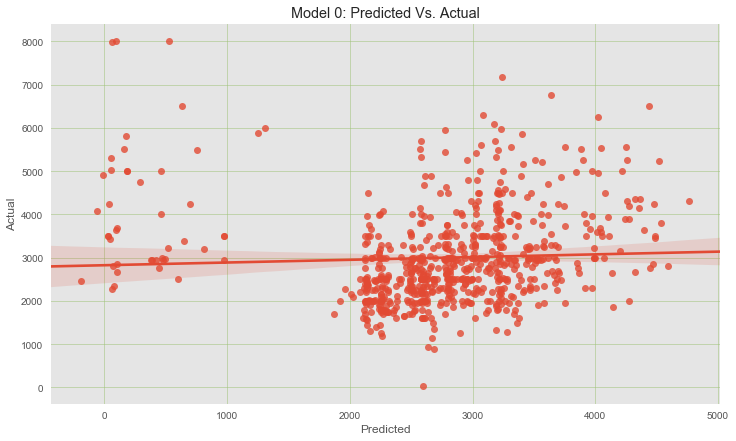

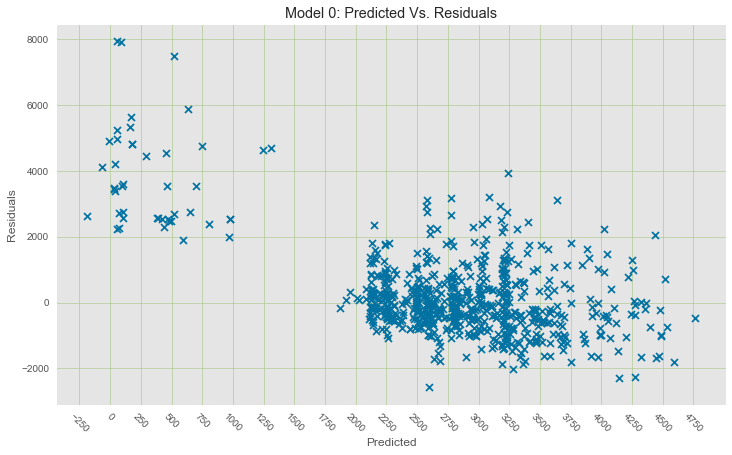

In [10]:
# define model target & features; exclude word_count, address, and zip columns:
X = df2.iloc[:, 1:23]
y = df2.iloc[:, 0]

# instantiate & fit statsmodels OLS:
model = sm.OLS(y, X)
fit = model.fit()

filename = '../data/ols-model-0.sav'
pickle.dump(model, open(filename, 'wb'))

# plot actual V. predicted:
plt.figure(figsize=(12,7))
plt.title('Model 0: Predicted Vs. Actual')
sns_plot = sns.regplot(x = fit.predict(), y = y, data = df2)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.grid(color = 'g', linewidth = 0.5)
sns_plot.figure.savefig('../visualizations/reg0.png')

# plot predicted V. residuals:
xt = range((int(min(fit.predict()))//250)*250, int(max(fit.predict())), 250)
plt.figure(figsize=(12,7))
plt.title('Model 0: Predicted Vs. Residuals')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.scatter(fit.predict(), fit.resid, color = 'b', marker = 'x')
plt.xticks(xt, rotation = -45)
plt.grid(color = 'g', linewidth = 0.5)

fit.summary()


Show relationship between `word_count` and predicted price per acre.

Total properies predicted under $1000 / acre: 43



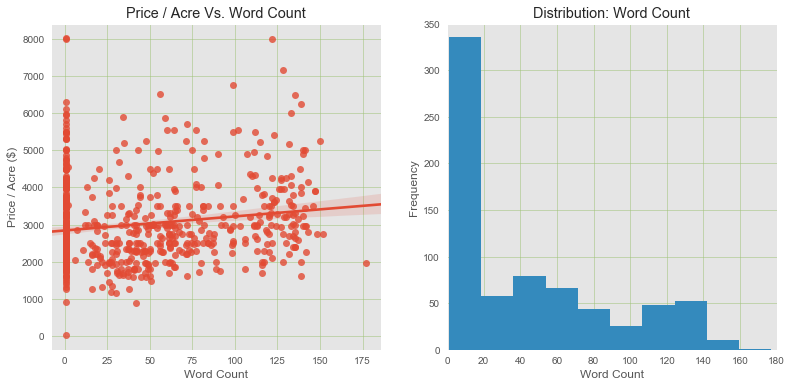

In [11]:
df_eval = pd.DataFrame(data = fit.predict(), columns = ['predicted'])
eval_mask = (df_eval.predicted < 1000)
print(f'Total properies predicted under $1000 / acre: {df_eval[eval_mask].shape[0]}\n')

# plot word_count V. price_acre regression & word_count distribution:
fig, ax = plt.subplots(1, 2, figsize = (13,6))

ax[0].set_title('Price / Acre Vs. Word Count')
sns.regplot(x = df2.word_count, y = df2.price_acre, data = df2, ax = ax[0])
ax[0].set(ylabel='Price / Acre ($)', xlabel = 'Word Count')

ax[1].set_title('Distribution: Word Count')
ax[1].hist(df2.word_count)
ax[1].set(ylabel='Frequency', xlabel = 'Word Count', ylim=(0, 350), xlim = (0, 180))

for ax in ax.flat:
    ax.grid(color = 'g', linewidth = 0.5)
    
fig.savefig('../visualizations/price_word_count.png')

# remove listings under 10 words:
df2 = df2.drop(df2[df2.word_count < 10].index)
df2.to_pickle('../data/pre-gis.pkl')

#### Feature Engineering:

The aforementioned verbosity premium suggested a need for additional features intrinsic to the land. Next to water, elevation is perhaps the region's most sought after land feature. Elevated properties are more likely to have vistas for home sites, channel wind for cooling, and provide better drainage for crops.

To find property elevation, the Google Maps API was employed. The GCP_Features function provides setup and error handling at the dataframe level, calls `get_GIS` to retrieve property data and then saves the new dataframe as a pickle file ('post-gis.pkl'). The `get_GIS` function first uses Google Maps Geocode API to get the latitude & longitude for a property address, and then sends these coordinates back to Google Maps Elevation API to get elevation.

In [ ]:
# running the following code requires a Google Cloud key:
df3 = GCP_Features(df2)

In [12]:
df3 = pickle.load(open('../data/post-gis.pkl', 'rb'))
print('Loaded dataframe of size', df3.shape)
df3.head()

Loaded dataframe of size (402, 25)


,price_acre,size,barn,cattle,easement,exemption,game_fence,lake,minerals,paved,...,bosque,coryell,falls,freestone,hill,limestone,mclennan,navarro,elevation,travel_time
60,3727.042826,241.21,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,748.621963,88.366667
62,2336.448598,214.00,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,528.527236,65.633333
64,2250.000000,60.84,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1143.658364,61.716667
65,1800.000000,192.00,0,1,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,473.634532,105.116667
66,3985.002587,135.29,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,657.578190,112.150000


#### Model-1:

Adjusting Model-0 for low word counts and additional features, we created a new baseline model that looks far better. The adjusted R^2 is a more realistic 22.2% with an intercept of $3,769 / acre. This constant represents a generalized price for ranchland in the area before applying any feature premiums or discounts and is consistent with domain knowledge.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             price_acre   R-squared:                       0.300
Model:                            OLS   Adj. R-squared:                  0.222
Method:                 Least Squares   F-statistic:                     3.836
Date:                Mon, 12 Aug 2019   Prob (F-statistic):           5.25e-08
Time:                        14:18:38   Log-Likelihood:                -1966.2
No. Observations:                 240   AIC:                             3982.
Df Residuals:                     215   BIC:                             4069.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        3768.8911    419.498      8.984      0.000    2942.036    4595.747
size           -0.1190      0.294     -0.404      0.686      -0.699       0.461
barn         -207.4991    321.025     -0.646      0.519    -840.259     425.261
cattle          9.2193    151.904      0.061      0.952    -290.193     308.632
easement      249.3710    456.082      0.547      0.585    -649.594    1148.336
exemption     225.5479    438.513      0.514      0.608    -638.787    1089.883
game_fence   -120.1858    678.746     -0.177      0.860   -1458.035    1217.663
lake          314.5876    206.026      1.527      0.128     -91.501     720.676
minerals      -40.3705    181.368     -0.223      0.824    -397.858     317.117
paved         -82.5948    191.661     -0.431      0.667    -460.370     295.180
pond         -112.5251    146.087     -0.770      0.442    -400.472     175.422
topo          261.1071    207.118      1.261      0.209    -147.135     669.349
water          73.9674    133.089      0.556      0.579    -188.360     336.295
well          175.9025    192.044      0.916      0.361    -202.627     554.432
windmill     -341.3157   1015.189     -0.336      0.737   -2342.313    1659.681
bosque        138.6446    346.852      0.400      0.690    -545.022     822.311
coryell      -395.2995    342.908     -1.153      0.250   -1071.191     280.592
falls        -912.4564    343.251     -2.658      0.008   -1589.025    -235.888
freestone    -961.8785    333.337     -2.886      0.004   -1618.905    -304.852
hill        -1034.0999    321.681     -3.215      0.002   -1668.153    -400.047
limestone   -1432.0155    333.387     -4.295      0.000   -2089.142    -774.889
mclennan     -283.5559    345.696     -0.820      0.413    -964.944     397.832
navarro     -1324.2618    350.391     -3.779      0.000   -2014.903    -633.621
elevation      -0.1568      0.403     -0.389      0.698      -0.951       0.638
travel_time    -0.1075      1.322     -0.081      0.935      -2.712       2.497
==============================================================================
Omnibus:                       31.865   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               42.391
Skew:                           0.868   Prob(JB):                     6.24e-10
Kurtosis:                       4.108   Cond. No.                     1.24e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.24e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

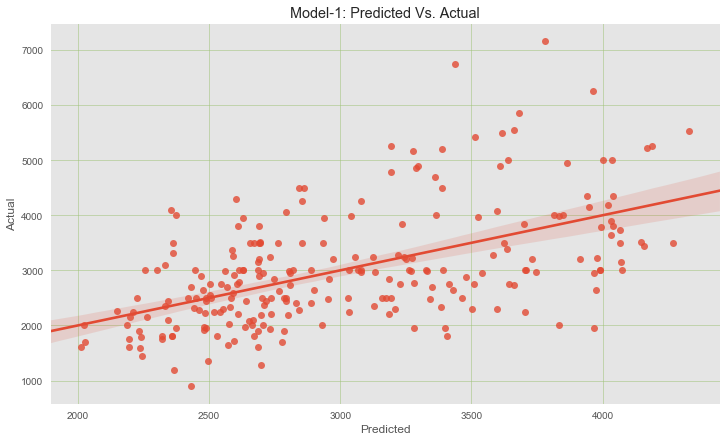

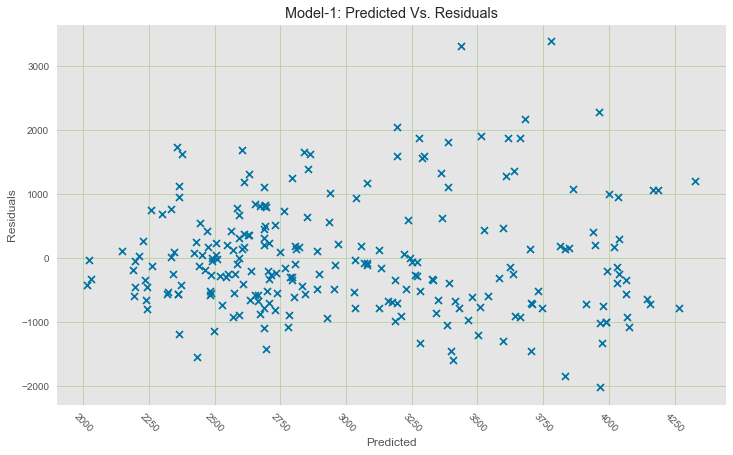

In [13]:
# define new model target & features:
X2 = df3.iloc[:, 1:]
y2 = df3.iloc[:, 0]

# split data into training / testing sets:
X2, X_test, y2, y_test = train_test_split(X2, y2, test_size = .2, random_state = 7)

# split training data into training data into training / validation sets:
X_train, X_val, y_train, y_val = train_test_split(X2, y2, test_size = .25, random_state = 3)

# instantiate & fit statsmodels OLS:
X_constant = sm.add_constant(X_train) # add intercept constant
model2 = sm.OLS(y_train, X_constant)
fit2 = model2.fit()

filename = '../data/ols-model-1.sav'
pickle.dump(model2, open(filename, 'wb'))

# plot actual V. predicted:
plt.figure(figsize=(12, 7))
plt.title('Model-1: Predicted Vs. Actual')
sns_plot = sns.regplot(fit2.predict(), y_train, data = df3)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.grid(color = 'g', linewidth = 0.5)

sns_plot.figure.savefig('../visualizations/reg1.png')

# plot predicted V. residuals:
xt = range((int(min(fit2.predict()))//250)*250, int(max(fit2.predict())), 250)
plt.figure(figsize=(12, 7))
plt.title('Model-1: Predicted Vs. Residuals')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.scatter(fit2.predict(), fit2.resid, color = 'b', marker = 'x')
plt.xticks(xt, rotation = -45)
plt.grid(color = 'g', linewidth = 0.5)

fit2.summary()

--------

#### Regression Part 2: Model Class Selection

Having established a baseline case for linear regression, model performance was compared across the following regression classes:

* Ridge
* Lasso
* Random Forest
* XG Boost
* K-Nearest Neighbors
* Multilayer Perception
* Polynomial
* Elastic Net

In [14]:
X3 = df3.iloc[:, 1:]
y3 = df3.iloc[:, 0]

X3, X_test, y3, y_test = train_test_split(X3, y3, test_size = .2, random_state = 123)

X3, y3 = np.array(X3), np.array(y3) # for kf indices generation below:

# set up KFold cross-validation & lists for results:
kf = KFold(n_splits = 5, shuffle = True, random_state = 123)
lm_reg_r2, lm_ridge_r2, lm_lasso_r2, rf_reg_r2, xgb_r2, knn_r2, mlp_r2 = [], [], [], [], [], [], []

# run cross-validation for each model class and score results:
for train_ind, val_ind in kf.split(X3, y3):
    
    X_train, y_train = X3[train_ind], y3[train_ind]
    X_val, y_val = X3[val_ind], y3[val_ind] 
    
    lm_reg = LinearRegression()
    lm_ridge = Ridge()
    lm_lasso = Lasso()
    rf_reg = RandomForestRegressor()
    xgb = XGBRegressor(max_depth = 4, n_estimators=30)
    knn = KNeighborsRegressor(n_neighbors = 5)
    mlp = MLPRegressor(hidden_layer_sizes=(30,))

    lm_reg.fit(X_train, y_train)
    lm_reg_r2.append(lm_reg.score(X_val, y_val))
    
    rf_reg.fit(X_train, y_train)
    rf_reg_r2.append(rf_reg.score(X_val, y_val))
    
    xgb.fit(X_train, y_train)
    xgb_r2.append(xgb.score(X_val, y_val))
    
    # feature scaling:
    scaler = StandardScaler()
    
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    lm_ridge.fit(X_train_scaled, y_train)
    lm_ridge_r2.append(lm_ridge.score(X_val_scaled, y_val))
    
    lm_lasso.fit(X_train_scaled, y_train)
    lm_lasso_r2.append(lm_lasso.score(X_val_scaled, y_val))

    knn.fit(X_train_scaled, y_train)
    knn_r2.append(knn.score(X_val_scaled, y_val))

    mlp.fit(X_train_scaled, y_train)
    mlp_r2.append(mlp.score(X_val_scaled, y_val))

# capture results to dataframes:
idx = ['Simple', 'Ridge', 'Lasso', 'RandomForest', 'XGB', 'KNN', 'MLP']
crossVal_df = pd.DataFrame(data = [lm_reg_r2, lm_ridge_r2, lm_lasso_r2, rf_reg_r2, xgb_r2, knn_r2, mlp_r2], 
                           columns = ['k1', 'k2', 'k3', 'k4', 'k5'],
                           index = idx)

temp_df = pd.DataFrame(columns = ['Mean', 'StanDev'])
temp_df.Mean = np.mean(crossVal_df, axis = 1)
temp_df.StanDev = np.std(crossVal_df, axis = 1)
crossVal_df['Mean'] = temp_df.Mean
crossVal_df['StanDev'] = temp_df.StanDev

print('Regression Model Validation Results Sorted by Mean R^2:\n')
pd.set_option('display.float_format', lambda x: '%.3f' % x)
crossVal_df.sort_values('Mean', ascending = False)

Regression Model Validation Results Sorted by Mean R^2:



,k1,k2,k3,k4,k5,Mean,StanDev
Lasso,0.229,0.200,0.249,0.147,0.125,0.190,0.047
Simple,0.228,0.198,0.246,0.148,0.118,0.188,0.048
Ridge,0.229,0.200,0.246,0.138,0.123,0.187,0.049
XGB,0.310,0.151,0.276,-0.014,-0.104,0.124,0.161
RandomForest,0.226,0.124,0.320,0.169,-0.303,0.107,0.215
KNN,0.142,0.044,0.165,-0.032,-0.102,0.043,0.101
MLP,-7.264,-9.247,-8.377,-6.274,-9.295,-8.091,1.170


#### Discussion:

Lasso, Ridge, a Simple Linear Regression performed the best and were tested below. In the test evaluation, Lasso preformed only half as well as Ridge. This could be due to the nature of a the dataset: many features have small, albeit non-zero impacts on property values which Lasso will take to zero but Ridge will only shrink.

In [15]:
print('Regression Model R^2 Test Results:\n') 

lm_reg.fit(X3, y3)
print(f'Simple: {lm_reg.score(X_test, y_test):.3f}')

lm_ridge.fit(X3, y3)
print(f'Ridge: {lm_ridge.score(X_test, y_test):.3f}')

lm_lasso.fit(X3, y3)
print(f'Lasso: {lm_lasso.score(X_test, y_test):.3f}')

Regression Model R^2 Test Results:

Simple: 0.253
Ridge: 0.227
Lasso: 0.247


#### Polynomial Regression:

In order to determine polynomial regression's performance, it should be tested across a range of degrees. The learning curve below shows the best result occurred at degree = 1, which is the same as a linear regression model, so we conclude that this model class is not useful and discard it.

Max R^2 of 0.118 occurred at polynomial degree = 1



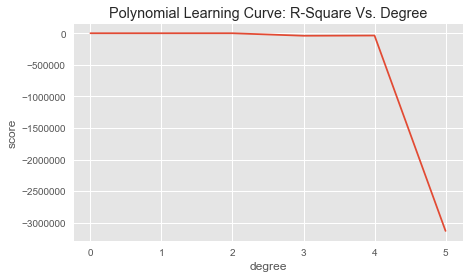

In [16]:
degs = np.arange(0, 6)
lm_poly_r2 = []

for i in range(len(degs)):
    lm_poly = LinearRegression()
    poly = PolynomialFeatures(degree = i) 

    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)

    lm_poly.fit(X_train_poly, y_train)
    lm_poly_r2.append(lm_poly.score(X_val_poly, y_val))

plt.figure(figsize = (7,4))
plt.plot(degs, lm_poly_r2)
plt.title('Polynomial Learning Curve: R-Square Vs. Degree')
plt.xlabel('degree')
plt.ylabel('score')
print(f'Max R^2 of {max(lm_poly_r2):.3f} occurred at polynomial degree = {lm_poly_r2.index(max(lm_poly_r2))}\n')

----

#### Model Optimization: Hyperparameter Tuning

Since Lasso & Regression are fundamentally dependent on the alpha parameter to penalize unimportant features, optimizing alpha is crucial to model performance. Using LassoCV and RidgeCV, we can test the models against a range of alpha parameters and find the value that minimizes error.

In [17]:
# create new data segment:
X4 = df3.iloc[:, 1:]
y4 = df3.iloc[:, 0]

X4, X_test, y4, y_test = train_test_split(X4, y4, test_size = .2, random_state = 123) 

X_train, X_val, y_train, y_val = train_test_split(X4, y4, test_size = .25, random_state = 123)

# compute optimum alphas:
alphas = np.logspace(-10, 2.5, 100)
scaler = StandardScaler()
scaler.fit(X_train.values)

# scale predictors on both the train and test set:
X_tr = scaler.transform(X_train.values)
X_va = scaler.transform(X_val.values)
X_te = scaler.transform(X_test.values)

# train, fit, and test models, computing %change over non-optimzed models:
ridge_cv = RidgeCV(alphas = alphas, cv = 5)
lm_ridge_cv = ridge_cv.fit(X_tr, y_train)
ridge_cv_alpha = lm_ridge_cv.alpha_
print(f'-- Optimized Ridge --\nAlpha: {ridge_cv_alpha:.2f}')
print(f'Validation: {lm_ridge_cv.score(X_va, y_val):.4f}')
print(f'Test: {lm_ridge_cv.score(X_te, y_test):.4f}')
ridge_delta = crossVal_df['Mean'].loc['Ridge']
print(f'>> R^2 Improvement: {100 * (lm_ridge_cv.score(X_te, y_test) - ridge_delta) / ridge_delta:.2f}%\n')

lasso_cv = LassoCV(alphas = alphas, cv = 5)
lm_lasso_cv = lasso_cv.fit(X_tr, y_train)
lasso_cv_alpha = lm_lasso_cv.alpha_
print(f'-- Optimized Lasso -- \nAlpha: {lasso_cv_alpha:.2f}')
print(f'Validation: {lm_lasso_cv.score(X_va, y_val):.4f}')
print(f'Test: {lm_lasso_cv.score(X_te, y_test):.4f}')
lasso_delta = crossVal_df['Mean'].loc['Lasso']
print(f'>> R^2 Improvement: {100 * (lm_lasso_cv.score(X_te, y_test) - lasso_delta) / lasso_delta:.2f}%\n')

-- Optimized Ridge --
Alpha: 55.26
Validation: 0.2735
Test: 0.1830
>> R^2 Improvement: -2.23%

-- Optimized Lasso -- 
Alpha: 7.22
Validation: 0.2706
Test: 0.1805
>> R^2 Improvement: -4.97%



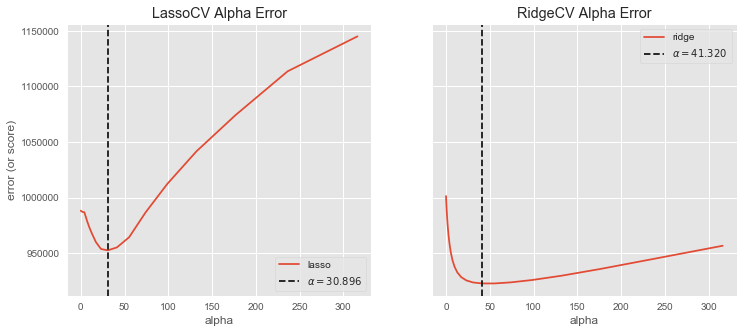

In [18]:
# visualize alpha selection with yellowbrick:
alphas = np.logspace(-10, 2.5, 100)

lm_lcv = LassoCV(alphas=alphas)
lm_rcv = RidgeCV(alphas=alphas)

mod_list = [lm_lcv, lm_rcv]

fig, ax = plt.subplots(1, 2, sharey = True, figsize = (12, 5))

for i in range(0, 2):
    mod = mod_list[i]
    viz = AlphaSelection(mod, ax = ax[i])
    viz.fit(X_tr, y_train)
    viz.finalize()
    
for ax in ax.flat:
    ax.label_outer()

#### Elastic Net:

Having optimized the Lasso & Ridge alpha parameters, we may find additional improvement by combining the best parts of both models: Elastic Net. The test & validation results for ElasticNetCV were nearly identical to running ElasticNet with GridSearchCV. However, the 
ElasticNetCV's `l1_ratio` evenly split the penalty term between Ridge & Lasso, whereas ElasticNet with GridSearchCV favored Lasso at 0.9. 

The coefficients for the optimized versions of our top 4 models were then plotted to visualize the price impact of each feature.


In [19]:
# ElasticNetCV:
lm_elastic_cv = ElasticNetCV()
lm_elastic_cv.fit(X_tr, y_train)

print(f'-- ElasticNetCV -- \nAlpha: {lm_elastic_cv.alpha_:.2f}')
print(f'L1 Ratio: {lm_elastic_cv.l1_ratio_:.2f}')
print(f'Validation: {lm_elastic_cv.score(X_va, y_val):.4f}')
print(f'Test: {lm_elastic_cv.score(X_te, y_test):.4f}\n')

# ElasticNet with GridSearchCV:
lm_elastic = ElasticNet()
parametersGrid = {'max_iter': np.arange(0, 30, 5),
                  'alpha': np.logspace(-3, 2, 100),
                  'l1_ratio': np.arange(0.0, 1.0, 0.1)}

grid = GridSearchCV(lm_elastic, parametersGrid, scoring = 'r2', cv = 5, n_jobs = -1)
grid.fit(X_tr, y_train)

print(f'-- ElasticNet + GridSearchCV -- \nAlpha: {grid.best_params_["alpha"]:.2f}')
print(f'L1 Ratio: {grid.best_params_["l1_ratio"]:.2f}')
print(f'Validation: {grid.score(X_va, y_val):.4f}')
print(f'Test: {grid.score(X_te, y_test):.4f}')

-- ElasticNetCV -- 
Alpha: 0.64
L1 Ratio: 0.50
Validation: 0.2685
Test: 0.1849

-- ElasticNet + GridSearchCV -- 
Alpha: 2.72
L1 Ratio: 0.90
Validation: 0.2695
Test: 0.1847


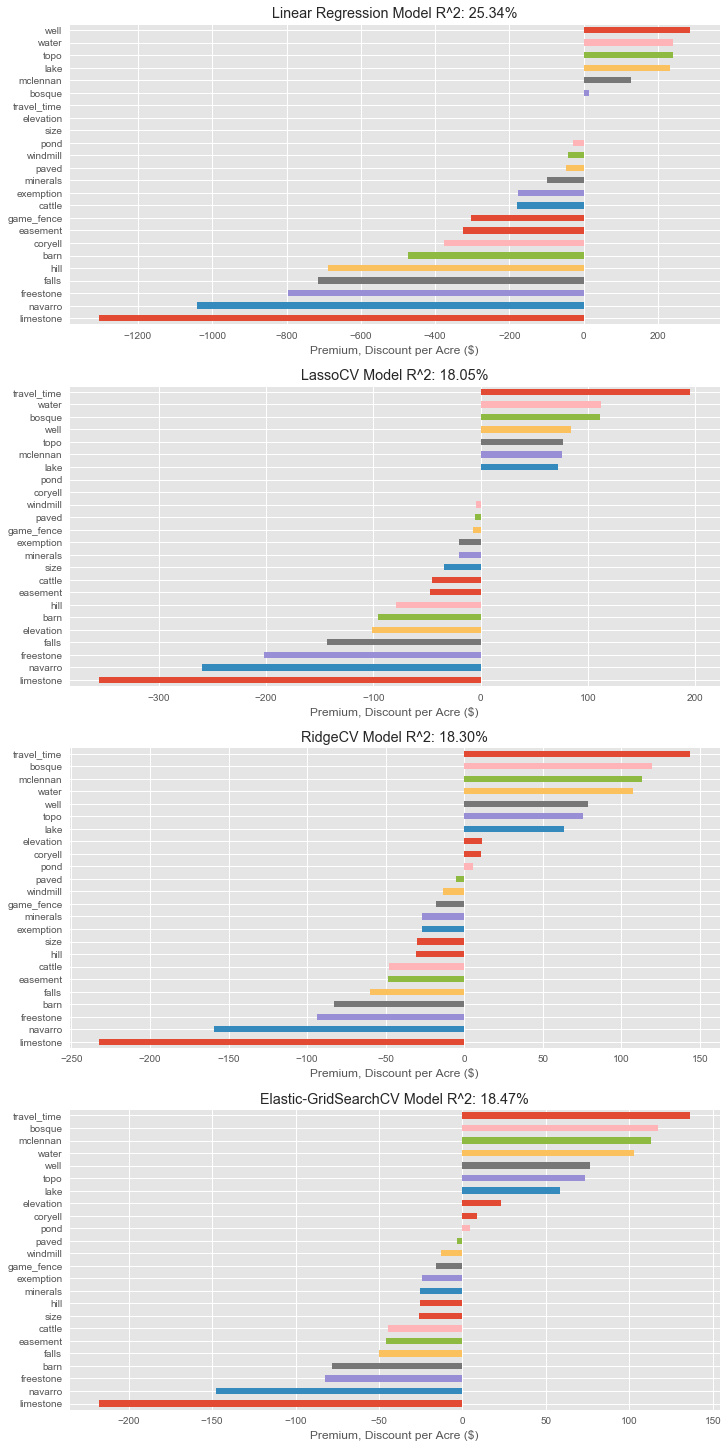

In [20]:
reg_list, r2_list = [lm_reg, lm_lasso_cv, lm_ridge_cv, grid], []
titles = ['Linear Regression', 'LassoCV', 'RidgeCV', 'Elastic-GridSearchCV']

# print r2 score for optimized models:
def print_R2(xtest, n):
    test_set_pred = reg_list[n].predict(xtest)
    r2_list.append(r2_score(y_test, test_set_pred))

for n in range(0, 4):
    if n == 0:
        print_R2(X_test, n)
    else:
        print_R2(X_te, n)
        
# plot coefficients sorted by impact:
fig, ax = plt.subplots(4, 1, figsize = (10,20), constrained_layout = True)

for i in range(4):
    mod = reg_list[i]
    if mod == grid:
        features = pd.Series(mod.best_estimator_.coef_, index = X4.columns).sort_values()
        features.plot(ax = ax[i], kind = 'barh')

    else:
        features = pd.Series(mod.coef_, index = X4.columns).sort_values()
        features.plot(ax = ax[i], kind = 'barh')
    ax[i].set_title(f'{titles[i]} Model R^2: {100*r2_list[i]:.2f}%')
    ax[i].set(xlabel = 'Premium, Discount per Acre ($)')

------

#### Conclusion:

At the end of the day, it proved difficult to beat Simple Linear Regression. Even the best models were unable to best a 30% coefficient of determination, largely resulting from the property description inaccuracy and variance. But although the models do not account for 70% of the variance, the feature impact on valuation is consistent with domain knowledge:

* Water features uniformly showed the greatest premium of $100 to $250 per acre
* Bosque & McClellan county are considered the regions best counties
* Agricultural features such as Barn & Cattle suggest land that is flat and open and were discounted accordingly

##### Surprises:

1. Oil & gas rights ownerships ("minerals") negatively impacted valuations. This would make sense if it could be demonstrated that brokers mention mineral rights to increase the appeal of less desirable land - oil has not been discovered in the region.

2. Properties with a greater travel time from the Dallas CBD were generally priced higher. This may be due to the desire for privacy and quiet. The tradeoff for remote properties with less highway noise is a less-navigable ingress, often a single-lane, dirt road only safe at lower speeds.

##### Future Work:

1. Data - Collecting more data would be the simplest way to improve model accuracy, but the source site changed design mid-project, making this untenable within the given timeline. 

2. GIS - Results could also be improved using GIS processing - not only to extract property features consistently across listings, but also to collect numerical measurements of said features: lake size.

3. Image Processing AI - A lot can be gleaned from a property's front gate, such as fence condition and whether the property is in disrepair. These images are accessible from Google's Street View API and could used to train a neural net. 